# Praca domowa 7
### Agata Kaczmarek

Celem tego zadania jest wykorzystanie algorytmu GMM do wykrywania próbek odstających. Po wytrenowaniu modelu należy go ocenić wykorzystując metryki: F1 score, Precision i Recall.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn import preprocessing
import seaborn as sns
import sklearn
from sklearn.metrics import precision_score, recall_score, f1_score

### Import danych oraz podział na testowe X i testowe Y:
Dane użyte do tego zadania zostały wyodrębnione ze zbioru [Wine UCI](https://archive.ics.uci.edu/ml/datasets/wine) i podzielone na trzy zbiory: train, test oraz val. Train to dane bez próbek odstających, do trenowania modelu, test mają dodaną informację o klasie (0=inliers, 1=outliers) oraz służą co oceny skuteczności modelu, val jest analogiczny do test, jednak nie zawiera informacji o klasie.

In [2]:
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")
df_val=pd.read_csv("val.csv")
df_test_Y=df_test.iloc[:,0]
df_test_X=df_test.iloc[:,1:]


Zobaczmy na początek jak wyglądają nasze dane z poszczególnych zbiorów oraz ile w zbiorze testowym jest outlierów.

In [18]:
df_train.describe()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,12.604211,2.436000,2.315895,20.662105,96.726316,2.018526,1.539579,0.400000,1.429263,4.941789,0.912589,2.307263,572.242105
std,0.682538,1.191029,0.298223,3.227778,13.737232,0.538838,0.822284,0.130245,0.550238,2.749656,0.260982,0.695243,148.401534
min,11.030000,0.740000,1.360000,10.600000,70.000000,1.100000,0.470000,0.130000,0.410000,1.280000,0.480000,1.270000,290.000000
25%,12.165000,1.430000,2.195000,18.500000,87.500000,1.620000,0.815000,0.290000,1.040000,2.875000,0.675000,1.675000,465.500000
50%,12.520000,2.130000,2.320000,20.000000,94.000000,1.950000,1.460000,0.400000,1.350000,3.850000,0.906000,2.260000,560.000000
75%,13.095000,3.280000,2.500000,22.500000,103.000000,2.310000,2.075000,0.500000,1.680000,6.550000,1.110000,2.915000,676.500000
max,14.340000,5.650000,3.230000,30.000000,151.000000,3.500000,5.080000,0.630000,3.580000,13.000000,1.710000,3.690000,985.000000


In [19]:
df_test.describe()

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.294118,12.905294,2.201176,2.338235,18.529412,101.352941,2.307059,1.984706,0.352353,1.684706,4.518235,0.958235,2.715882,732.941176
std,0.469668,0.917933,1.223887,0.234287,3.336683,21.002801,0.619049,1.073191,0.141268,0.800540,1.914416,0.203108,0.612689,328.074967
min,0.000000,11.810000,0.890000,1.880000,11.200000,80.000000,1.280000,0.470000,0.140000,0.420000,2.060000,0.540000,1.750000,278.000000
25%,0.000000,12.000000,1.520000,2.200000,17.000000,86.000000,1.650000,0.990000,0.220000,1.150000,2.800000,0.790000,2.260000,520.000000
50%,0.000000,12.870000,1.730000,2.360000,19.000000,96.000000,2.500000,2.210000,0.320000,1.560000,4.380000,0.950000,2.730000,625.000000
75%,1.000000,13.580000,2.810000,2.480000,21.000000,106.000000,2.860000,3.000000,0.470000,2.030000,6.380000,1.050000,3.170000,970.000000
max,1.000000,14.750000,4.610000,2.740000,22.500000,162.000000,3.200000,3.690000,0.600000,3.280000,7.650000,1.380000,3.640000,1515.000000


In [17]:
df_test['class'].value_counts()

0    12
1     5
Name: class, dtype: int64

In [20]:
df_val.describe()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,13.258235,2.659412,2.385294,20.682353,93.470588,2.302941,2.132353,0.358235,1.524706,4.899412,0.911765,2.675882,649.235294
std,0.744767,1.400185,0.213662,2.634918,9.240655,0.747761,1.156901,0.116148,0.469882,2.363479,0.220659,0.739443,280.013287
min,12.040000,1.070000,2.100000,14.000000,80.000000,0.980000,0.340000,0.190000,0.550000,2.060000,0.580000,1.330000,315.000000
25%,12.430000,1.610000,2.230000,19.500000,86.000000,1.680000,0.750000,0.280000,1.350000,3.380000,0.720000,2.060000,410.000000
50%,13.480000,1.900000,2.300000,21.500000,90.000000,2.530000,2.610000,0.370000,1.660000,4.500000,0.890000,2.850000,615.000000
75%,13.780000,3.370000,2.500000,22.000000,100.000000,2.800000,2.980000,0.410000,1.870000,5.200000,1.060000,3.160000,845.000000
max,14.830000,5.800000,2.800000,25.000000,108.000000,3.520000,3.750000,0.660000,2.040000,10.260000,1.360000,3.820000,1285.000000


### Trenowanie GMM
Wytrenujmy nasz model.

In [3]:
gmm = mixture.GaussianMixture(n_components=1, covariance_type='full')
gmm.fit(df_train)

GaussianMixture()

'score_samples' oblicza ważone prawdopodobieństwo logarytmiczne dla danej próbki. Narysuję teraz histogram, z którego będę mogła odczytać, jakie są najmniejsze wartości tego prawdopodobieństwa.

In [4]:
train_after_gmm=gmm.score_samples(df_train)
val_after_gmm=gmm.score_samples(df_val)

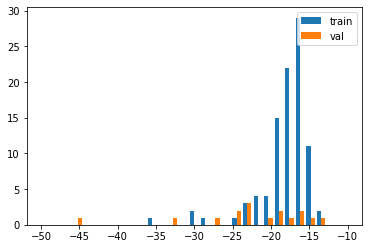

In [5]:
bins = np.linspace(-50, -10, 30)
plt.hist([train_after_gmm, val_after_gmm], bins, label=['train', 'val'])
plt.legend(loc='upper right')
plt.show()

Patrząc na niebieskie słupki (dane treningowe) uznaję, że dla wartości mniejszych niż -30 będzimey mieć już do czynienia z outlierami.

Zobaczmy jak to będzie wyglądało dla danych testowych.

In [6]:
treshold_out=-30

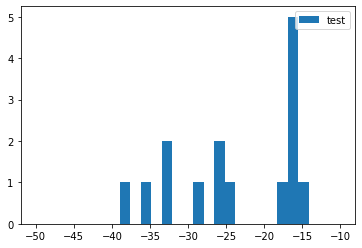

In [7]:
test_after_gmm=gmm.score_samples(df_test_X)
plt.hist([test_after_gmm], bins, label=['test'])
plt.legend(loc='upper right')
plt.show()

Faktycznie jest część wyników mających wartości mniejsze niż -30, ale większość ma większe.

### Sprawdzenie metryk

Sprawdzę teraz działanie tak zmienionego gmm metrykami: precision, recall, F1 score.

In [8]:
def scores(y_true, y_pred, average='weighted'):
    precision=precision_score(y_true, y_pred, average=average)
    recall=recall_score(y_true, y_pred, average=average)
    f1=f1_score(y_true, y_pred, average=average)
    score=pd.DataFrame({'precision score':[precision], 
    'recall score':[recall], 'F1 score': [f1]}, index=[average])
    print(score)


In [9]:
scores(df_test_Y, treshold_out>test_after_gmm)

          precision score  recall score  F1 score
weighted          0.95098      0.941176  0.942571


### Wnioski

Wyniki tych metryk wyglądają dobrze, więc GMM może służyć do znajdowania obserwacji odstających.